# 2. Topic Modeling - Latent Dirchlet Allocation (LDA) + time dimension

In [1]:
# format code
# pip install nb_black
%load_ext nb_black

<IPython.core.display.Javascript object>

In [2]:
import pickle
import numpy as np
import pandas as pd
import re
import scipy.sparse
import gensim
import matplotlib.pyplot as plt
from gensim.corpora import Dictionary
from gensim import matutils
from gensim import models
from gensim.models.coherencemodel import CoherenceModel
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer

<IPython.core.display.Javascript object>

### comment condition:  >15words AND 10 unique words

In [3]:
stop_words = set(stopwords.words("german"))
stop_words_add = [
    "mal",
    "mehr",
    "ja",
    "schon",
    "gibt",
    "geht",
    "hast",
    "einfach",
    "ganz",
    "macht",
    "immer",
    "tun",
    "viele",
    "wer",
    "sagen",
    "wäre",
    "genau",
    "dafür",
    "natürlich",
    "seit",
    "wurde",
    "eigentlich",
    "kommt",
    "gesagt",
    "sagt",
    "nie",
    "sehen",
    "deren",
    "versuchen",
    "empfehlen",
    "müssen",
    "kurz",
    "wenig",
    "erste",
    "klare",
    "gar",
    "grad",
    "wohl",
    "oft",
    "ha",
    "schaffen",
    "daher",
    "schreibt",
    "ständig",
    "völlig",
    "verdient",
    "worden",
    "solange",
    "könnt",
    "mann",
    "zeigt",
    "später",
    "erste",
    "iwelche",
    "wen",
    "eigenem",
    "gründen",
    "ups",
    "irgendjemand",
    "wuerde",
    "gründen",
]
sw = set(list(stop_words) + stop_words_add)

<IPython.core.display.Javascript object>

In [4]:
corpora_names = [
    "2019-05",
    "2019-06",
    "2019-07",
    "2019-08",
    "2019-09",
    "2019-10",
    "2019-11",
    "2019-12",
    "2020-01",
    "2020-02",
    "2020-03",
    "2020-04",
    "2020-05",
    "2020-06",
    "2020-07",
    "2020-08",
    "2020-09",
    "2020-10",
    "2020-11",
    "2020-12",
    "2021-01",
    "2021-02",
    "2021-03",
    "2021-04",
    "2021-05",
    "2021-06",
    "2021-07",
    "2021-08",
]
corpora_docs = [
    131917,
    14823,
    2644,
    2395,
    1875,
    1167,
    1290,
    1370,
    1064,
    1136,
    1039,
    1567,
    1392,
    1859,
    1705,
    2102,
    1843,
    1976,
    2142,
    1510,
    3090,
    8059,
    9025,
    11319,
    6833,
    3285,
    9394,
    1727,
]
corpora_info = list(zip(corpora_names, corpora_docs))
print(corpora_info)

[('2019-05', 131917), ('2019-06', 14823), ('2019-07', 2644), ('2019-08', 2395), ('2019-09', 1875), ('2019-10', 1167), ('2019-11', 1290), ('2019-12', 1370), ('2020-01', 1064), ('2020-02', 1136), ('2020-03', 1039), ('2020-04', 1567), ('2020-05', 1392), ('2020-06', 1859), ('2020-07', 1705), ('2020-08', 2102), ('2020-09', 1843), ('2020-10', 1976), ('2020-11', 2142), ('2020-12', 1510), ('2021-01', 3090), ('2021-02', 8059), ('2021-03', 9025), ('2021-04', 11319), ('2021-05', 6833), ('2021-06', 3285), ('2021-07', 9394), ('2021-08', 1727)]


<IPython.core.display.Javascript object>

In [5]:
corpus = pd.read_pickle("data/pickle/corpus_clean.pkl")
corpus

,comment
0,feier sowas endlich jemand alten cdu stimme ni...
1,achtung faschisten irma lo beleidigt user ganz...
2,zeigt jahre jahre
3,doppelmoralist rezo eigenes video dezember pri...
4,richtig
...,...
229571,legalisierung mehr fahrverbote läuft
229572,j pepe leg fakten falsche informationen rausha...
229573,bundestag stehen abgeordnete mandat halten unt...
229574,liebe user lasst daran hindern frei meinung ek...


<IPython.core.display.Javascript object>

In [6]:
idx = 0
# idx_min = 0
# idx_max = corpus.shape[0]  # number of rows (documents in corpus)
corpus_d = {}

for i, t in enumerate(corpora_info):
    lb = idx
    rb = idx + t[1]

    corpus_d[t[0]] = {
        "len": t[1],
        "corpora": pd.DataFrame(data=corpus.iloc[lb:rb]),
    }
    assert corpus_d[t[0]]["len"] == corpus_d[t[0]]["corpora"].shape[0]
    idx += t[1] + 1

<IPython.core.display.Javascript object>

In [7]:
MIN_WORDS = 15
MIN_UNIQUE_WORDS = 10
progress = 0
print("")

for key, value in corpus_d.items():
    value["texts"] = []
    doc_to_drop = []

    for i in list(value["corpora"].index):
        progress += 1
        if len(value["corpora"].loc[i].comment.split()) < MIN_WORDS:
            doc_to_drop.append(i)
        elif len(set(value["corpora"].loc[i].comment.split())) < MIN_UNIQUE_WORDS:
            doc_to_drop.append(i)
        else:
            # (list of list of str) Tokenized texts, needed for coherence models
            value["texts"].append(value["corpora"].loc[i].comment.split())

        if progress % 100 == 0:
            print(f"progress: {progress}/{sum(corpora_docs)}", end="\r")

    value["corpora"] = value["corpora"].drop(index=doc_to_drop)

    d_ = {}
    for i, v in enumerate(list(value["corpora"].index)):
        d_[v] = i
    value["corpora"] = value["corpora"].rename(index=d_)

print("")


progress: 229500/229548


<IPython.core.display.Javascript object>

In [8]:
corpora_filtered_info = [
    (key, len(value["corpora"].index)) for key, value in corpus_d.items()
]
print(corpora_filtered_info)

[('2019-05', 50298), ('2019-06', 5416), ('2019-07', 826), ('2019-08', 745), ('2019-09', 591), ('2019-10', 360), ('2019-11', 412), ('2019-12', 445), ('2020-01', 357), ('2020-02', 361), ('2020-03', 375), ('2020-04', 502), ('2020-05', 421), ('2020-06', 600), ('2020-07', 544), ('2020-08', 618), ('2020-09', 581), ('2020-10', 634), ('2020-11', 663), ('2020-12', 468), ('2021-01', 893), ('2021-02', 2542), ('2021-03', 2876), ('2021-04', 3664), ('2021-05', 2138), ('2021-06', 1031), ('2021-07', 2986), ('2021-08', 541)]


<IPython.core.display.Javascript object>

In [9]:
docs_post_filtering = [x[1] for x in corpora_filtered_info]
print(f" docs per month (post filtering):\n {docs_post_filtering}")
print(f"\n nr docs (post filtering): {sum(docs_post_filtering)}")

 docs per month (post filtering):
 [50298, 5416, 826, 745, 591, 360, 412, 445, 357, 361, 375, 502, 421, 600, 544, 618, 581, 634, 663, 468, 893, 2542, 2876, 3664, 2138, 1031, 2986, 541]

 nr docs (post filtering): 81888


<IPython.core.display.Javascript object>

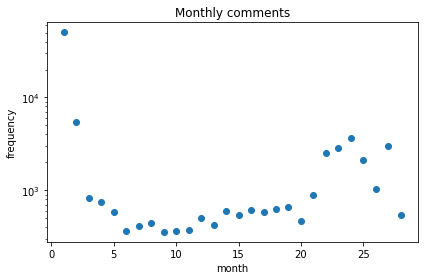

<IPython.core.display.Javascript object>

In [10]:
# scatterplot months
plt.scatter(range(1, len(docs_post_filtering) + 1), docs_post_filtering)
plt.title("Monthly comments")
plt.xlabel("month")
plt.ylabel("frequency")
plt.yscale("log")

plt.savefig("data/pdf/scatter_comments_post_filtering_tm_log.pdf", bbox_inches="tight")

plt.tight_layout()
plt.show()

In [11]:
corpora_filtered_percentage = [
    (x[0][0], (round(1 - (x[0][1] / x[1][1]), 2)))
    for x in list(zip(corpora_filtered_info, corpora_info))
]
corpora_filtered_percentage

[('2019-05', 0.62),
 ('2019-06', 0.63),
 ('2019-07', 0.69),
 ('2019-08', 0.69),
 ('2019-09', 0.68),
 ('2019-10', 0.69),
 ('2019-11', 0.68),
 ('2019-12', 0.68),
 ('2020-01', 0.66),
 ('2020-02', 0.68),
 ('2020-03', 0.64),
 ('2020-04', 0.68),
 ('2020-05', 0.7),
 ('2020-06', 0.68),
 ('2020-07', 0.68),
 ('2020-08', 0.71),
 ('2020-09', 0.68),
 ('2020-10', 0.68),
 ('2020-11', 0.69),
 ('2020-12', 0.69),
 ('2021-01', 0.71),
 ('2021-02', 0.68),
 ('2021-03', 0.68),
 ('2021-04', 0.68),
 ('2021-05', 0.69),
 ('2021-06', 0.69),
 ('2021-07', 0.68),
 ('2021-08', 0.69)]

<IPython.core.display.Javascript object>

In [12]:
corpora_filtered_documents_f = [x[1] for x in corpora_filtered_info]
corpora_filtered_documents_sum = sum(corpora_filtered_documents_f)
corpora_filtered_documents_min = min(corpora_filtered_documents_f)
corpora_filtered_documents_max = max(corpora_filtered_documents_f)
corpora_filtered_documents_mean = np.mean(corpora_filtered_documents_f)
corpora_filtered_documents_median = np.median(corpora_filtered_documents_f)
print(f"sum docs: {corpora_filtered_documents_sum}")
print("")
print(f"min docs: {corpora_filtered_documents_min}")
print(f"max docs: {corpora_filtered_documents_max}")
print("")
print(f"mean docs: {corpora_filtered_documents_mean}")
print(f"median docs: {corpora_filtered_documents_median}")

sum docs: 81888

min docs: 357
max docs: 50298

mean docs: 2924.5714285714284
median docs: 609.0


<IPython.core.display.Javascript object>

In [13]:
for key, value in corpus_d.items():
    value["tfidf_vectorizer"] = TfidfVectorizer(stop_words=sw)
    value["tfidf_wm"] = value["tfidf_vectorizer"].fit_transform(
        value["corpora"].comment
    )
    value["tfidf"] = pd.DataFrame(
        value["tfidf_wm"].toarray(),
        columns=value["tfidf_vectorizer"].get_feature_names(),
    )
    value["tfidf"].index = value["corpora"].index
    value["tfidf"] = value["tfidf"].transpose()

<IPython.core.display.Javascript object>

In [14]:
for key, value in corpus_d.items():
    value["dictionary"] = Dictionary(value["texts"])
    value["sparse_counts"] = scipy.sparse.csr_matrix(value["tfidf"])
    value["corpus_sparse"] = matutils.Sparse2Corpus(value["sparse_counts"])
    value["id2word"] = dict(
        (v, k) for k, v in value["tfidf_vectorizer"].vocabulary_.items()
    )

<IPython.core.display.Javascript object>

###  evaluate number of topics for each month

In [15]:
start = 8
limit = 20
step = 1
print("")

for key, value in corpus_d.items():
    value["lda_models"] = []
    print(f"processing: {key}", end="\r")

    for num_topics in range(start, limit, step):
        # list of tuple of model,coherence
        lda_model = models.LdaModel(
            corpus=value["corpus_sparse"],
            id2word=value["id2word"],
            num_topics=num_topics,
            random_state=100,
            update_every=1,
            passes=10,
            alpha="auto",
        )
        coherence_model = CoherenceModel(
            model=lda_model,
            texts=value["texts"],
            dictionary=value["dictionary"],
        )
        value["lda_models"].append((lda_model, coherence_model.get_coherence()))

print("")


processing: 2021-08


<IPython.core.display.Javascript object>

In [16]:
for key, value in corpus_d.items():
    print(f"## {key}")
    lda_coherence_values = [x[1] for x in value["lda_models"]]
    num_topics_lda = list(range(start, limit, step))

    assert len(num_topics_lda) == len(lda_coherence_values)

    print(list(zip([str(x) + " Topics" for x in num_topics_lda], lda_coherence_values)))
    print("\n\n")

## 2019-05
[('8 Topics', 0.7538501407716326), ('9 Topics', 0.7468919594432979), ('10 Topics', 0.7482827332737104), ('11 Topics', 0.742377896285947), ('12 Topics', 0.7567082498102687), ('13 Topics', 0.7410050991671788), ('14 Topics', 0.7422013578009288), ('15 Topics', 0.7415983718736363), ('16 Topics', 0.7409633593788693), ('17 Topics', 0.7453045672190993), ('18 Topics', 0.7369976727135255), ('19 Topics', 0.7451530182507343)]



## 2019-06
[('8 Topics', 0.7639319848363995), ('9 Topics', 0.7621498139510291), ('10 Topics', 0.7539145784465456), ('11 Topics', 0.7592582517262649), ('12 Topics', 0.7595723058034989), ('13 Topics', 0.7584122273840352), ('14 Topics', 0.7644022868554898), ('15 Topics', 0.7543041211125876), ('16 Topics', 0.7529547631068527), ('17 Topics', 0.7560506392831872), ('18 Topics', 0.7625133466710894), ('19 Topics', 0.7523167115983418)]



## 2019-07
[('8 Topics', 0.7718374638167718), ('9 Topics', 0.7680639632480235), ('10 Topics', 0.7703084361414156), ('11 Topics', 0.7696

<IPython.core.display.Javascript object>

In [33]:
# get *best* 28 models
num_topics_max_coherence = []

for key, value in corpus_d.items():
    max_coherence = max([x[1] for x in value["lda_models"]])
    nr_topics = None
    for i, t in enumerate(value["lda_models"]):
        if t[1] == max_coherence:
            nr_topics = start + step * i
    num_topics_max_coherence.append((key, nr_topics, max_coherence))

assert len(num_topics_max_coherence) == 28
print(f"nr topics with max coherence per month: \n")
for t in num_topics_max_coherence:
    print(f"{t[0]}  %2s  {t[2]}" % t[1])

nr topics with max coherence per month: 

2019-05  12  0.7567082498102687
2019-06  14  0.7644022868554898
2019-07  15  0.7771677604207207
2019-08   8  0.8026387157876548
2019-09  17  0.7948615528090829
2019-10  18  0.7870365985312643
2019-11  11  0.7923507441866623
2019-12   8  0.8040753880855329
2020-01   9  0.798367044398691
2020-02   8  0.810278755891862
2020-03  14  0.7868903610697586
2020-04  10  0.7992218955535711
2020-05  10  0.7885925353560453
2020-06  11  0.7983027800076844
2020-07  14  0.784859127773749
2020-08  19  0.7889074477891507
2020-09  10  0.8069997197974954
2020-10  17  0.7788247762503189
2020-11   8  0.7909834539344096
2020-12   8  0.8094797705144077
2021-01   9  0.7890934517402015
2021-02  16  0.7790533694895352
2021-03  13  0.7754975292184737
2021-04  10  0.7736846386955791
2021-05   8  0.7874238844459001
2021-06   9  0.7969093756974258
2021-07   9  0.7689660801935618
2021-08  15  0.7881215020457588


<IPython.core.display.Javascript object>

In [34]:
print(f"nr topics mean: {np.mean([x[1] for x in num_topics_max_coherence])}")
print(f"nr topics median: {np.median([x[1] for x in num_topics_max_coherence])}")

nr topics mean: 11.785714285714286
nr topics median: 10.5


<IPython.core.display.Javascript object>

### evaluate best equal number of topics

In [35]:
print(f"pre coherence mean: {np.mean([x[2] for x in num_topics_max_coherence])}")
print(f"pre coherence median: {np.median([x[2] for x in num_topics_max_coherence])}")

pre coherence mean: 0.7885606712982234
pre coherence median: 0.788749991572598


<IPython.core.display.Javascript object>

In [36]:
d_lda_model_stats_equal_nr_topics = {}

for nr_topics_for_model in range(start, limit, step):
    topic_idx = int((nr_topics_for_model - start) / step)
    for i, (key, value) in enumerate(corpus_d.items()):
        if nr_topics_for_model not in d_lda_model_stats_equal_nr_topics:
            d_lda_model_stats_equal_nr_topics[nr_topics_for_model] = []
        d_lda_model_stats_equal_nr_topics[nr_topics_for_model].append(
            (
                key,
                nr_topics_for_model,
                value["lda_models"][topic_idx][1],
            )
        )
    assert len(d_lda_model_stats_equal_nr_topics[nr_topics_for_model]) == 28

num_topics_mean_coherence = []

for key, value in d_lda_model_stats_equal_nr_topics.items():
    coherence_values = [x[2] for x in value]
    num_topics_mean_coherence.append((key, np.mean(coherence_values)))

num_topics_mean_coherence.sort(key=lambda t: t[1], reverse=True)
print(num_topics_mean_coherence)

[(8, 0.783418480180378), (9, 0.7816837331039215), (10, 0.7815146313005118), (11, 0.7810492965420675), (12, 0.7806564044427399), (14, 0.7802279984189354), (17, 0.779545939833146), (16, 0.7786046998804508), (15, 0.7784131710683743), (13, 0.778369814260505), (19, 0.7778513198320244), (18, 0.7773245150017184)]


<IPython.core.display.Javascript object>

In [37]:
# choose best coherence mean for equal number of topics
optimal_eq_num_topics = d_lda_model_stats_equal_nr_topics[
    num_topics_mean_coherence[0][0]
]

<IPython.core.display.Javascript object>

In [38]:
print(f"post coherence mean: {np.mean([x[2] for x in optimal_eq_num_topics])}")
print(f"post coherence median: {np.median([x[2] for x in optimal_eq_num_topics])}")

post coherence mean: 0.783418480180378
post coherence median: 0.7839842929411098


<IPython.core.display.Javascript object>

In [39]:
optimal_eq_num_topics

[('2019-05', 8, 0.7538501407716326),
 ('2019-06', 8, 0.7639319848363995),
 ('2019-07', 8, 0.7718374638167718),
 ('2019-08', 8, 0.8026387157876548),
 ('2019-09', 8, 0.7850299910869332),
 ('2019-10', 8, 0.7830121545492242),
 ('2019-11', 8, 0.7882739861080776),
 ('2019-12', 8, 0.8040753880855329),
 ('2020-01', 8, 0.7951321040068811),
 ('2020-02', 8, 0.810278755891862),
 ('2020-03', 8, 0.7734293205377498),
 ('2020-04', 8, 0.7842819161236574),
 ('2020-05', 8, 0.7875571205064611),
 ('2020-06', 8, 0.7956659090519039),
 ('2020-07', 8, 0.7699266942343428),
 ('2020-08', 8, 0.7820313416984813),
 ('2020-09', 8, 0.7999341091383096),
 ('2020-10', 8, 0.7713746446244456),
 ('2020-11', 8, 0.7909834539344096),
 ('2020-12', 8, 0.8094797705144077),
 ('2021-01', 8, 0.7813830489851572),
 ('2021-02', 8, 0.7770067446044354),
 ('2021-03', 8, 0.7661431415886095),
 ('2021-04', 8, 0.7629061886488997),
 ('2021-05', 8, 0.7874238844459001),
 ('2021-06', 8, 0.7869850088156198),
 ('2021-07', 8, 0.7674577928982601),
 (

<IPython.core.display.Javascript object>

### inteprete: top 10 keywords -> topic

In [56]:
nr_words = 10


def get_topics_format(topics):
    topics_words = []
    for topic in topics:
        s = topic[1].split("+")
        s = [tuple(x.split("*")) for x in s]
        weights = [float(x[0]) for x in s]
        words = [x[1].replace('"', "") for x in s]
        topics_words.append(list(zip(words, weights)))
    return topics_words


for idx, (key, value) in enumerate(corpus_d.items()):
    nr_t = optimal_eq_num_topics[idx][1]
    lda_index = int((nr_t - start) / step)
    coherence_value = value["lda_models"][lda_index][1]
    print(f"## {key} | {nr_t} Topics | coherence {coherence_value} | \n")

    weights = []

    for i, topic_words in enumerate(
        get_topics_format(
            value["lda_models"][lda_index][0].print_topics(num_words=nr_words)
        )
    ):
        weights_mean = sum([x[1] for x in topic_words]) / len(topic_words)
        relative_weight = weights_mean * len(topic_words)
        weights.append(relative_weight)

    # normalize sum of relative weights to 1 (0.9999)
    assert len(weights) == nr_t
    weights_sum = sum(weights)
    weights = [round(x * (1 / weights_sum), 4) for x in weights]
    weights_sum = sum(weights)
    assert abs(1 - weights_sum) <= 0.001

    for i, topic_words in enumerate(
        get_topics_format(
            value["lda_models"][lda_index][0].print_topics(num_words=nr_words)
        )
    ):
        weights_mean = sum([x[1] for x in topic_words]) / len(topic_words)
        print(
            f"### Topic: {i+1} | weights_mean: {round(weights_mean,4)} | relative weight: {weights[i]}"
        )
        print(topic_words, "\n")

    print("\n\n")

## 2019-05 | 8 Topics | coherence 0.7538501407716326 | 

### Topic: 1 | weights_mean: 0.0196 | relative weight: 0.1579
[('zitat ', 0.032), ('grünen ', 0.024), ('sebastian ', 0.018), ('striegel ', 0.018), ('zuwanderung ', 0.018), ('volkstod ', 0.018), ('subjekte ', 0.017), ('unterstellen ', 0.017), ('brandstifter ', 0.017), ('geistige', 0.017)] 

### Topic: 2 | weights_mean: 0.0184 | relative weight: 0.1483
[('unterstellungen ', 0.023), ('maniac ', 0.022), ('lügen ', 0.022), ('gollum ', 0.02), ('beleidigungen ', 0.019), ('cordes ', 0.018), ('axel ', 0.018), ('anna ', 0.014), ('lena ', 0.014), ('faschistischen', 0.014)] 

### Topic: 3 | weights_mean: 0.0058 | relative weight: 0.0467
[('video ', 0.011), ('cdu ', 0.007), ('afd ', 0.006), ('rezo ', 0.005), ('wählen ', 0.005), ('menschen ', 0.005), ('politik ', 0.005), ('danke ', 0.005), ('gut ', 0.005), ('deutschland', 0.004)] 

### Topic: 4 | weights_mean: 0.0182 | relative weight: 0.1467
[('user ', 0.026), ('liebe ', 0.024), ('daran ', 0.

<IPython.core.display.Javascript object>